# Práctica 1: Modelo de lenguaje para la detección de idioma

**Materia:** Procesamiento del Lenguaje Humano - GIA (UPC)  
**Autores:** Taisiia Prymak & Jiahui Chen


In [2]:
import re
from nltk.collocations import TrigramCollocationFinder
from math import log
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


## Preprocesamiento

Se cnstruyen las dos funciones que se usarán posteriormente en el proceso de entrenamiento y test.   

**En la carpeta de entrega hay un ejemplo de output.txt que es el resultado de ser preprocesado como un fichero train**.

In [ ]:
def preprocess_train(text):
    text = text.lower()  # Minúsculas
    # eliminar caracteres especiales relacionados con los dígitos.
    text = re.sub(r'[%)($:]', '', text)  
    # eliminar el dígito y el espacio después del dígito.
    text = re.sub(r'\d ', '', text)
    # eliminar los dígitos que no están seguidos de un espacio.
    # Se podría ampliar significativamente el preprocessing, sobre todo 
    # los puntos entre los dígitos o otros signos de puntuación irazonables.
    text = re.sub(r'\d', '', text)
    text = re.sub(' {2,}', ' ', text) # eliminar espacios en blanco continuos de 2 o más
    text = re.sub(r'\n', '  ', text) # eliminar saltos de línea y 
    # reemplazarlos por doble espacio para concatenar las oraciones.
    text = re.sub(r'\t', '', text) # eliminar tabulaciones
    return text                     

In [4]:
def preproces_test(text):
    text = preprocess_train(text) # Reutilizar la función anterior
    text = re.split(r'\s{2,}', text.strip()) # Separar las frases teniendo en cuando que se separan por dos espacios.
    text = [f"  {text.strip()}  " for text in text]  # Añade dos espacios al inicio y al final de cada frase.
    return text


## Construcción del modelo y train

Nuestro modelo de lenguaje para la detección del idioma es paramétrico, por tanto, necesitamos estimar los parámetros que constituyen el modelo. 
 
También está la función que representa el kernel del nuestro modelo, la función que computa la probabilidad de versemblanza de un corpus de entrada a un conjunto de idiomas, los cuales tenemos un corpus de entreno. 

In [5]:
def find_parameters(text):
    finder = TrigramCollocationFinder.from_words(text)
    dic = {}# Las ci ocurrencias del trigrama es el valor en el diccionario
    N = 0
    for k, v in finder.ngram_fd.items(): # N supongo qu es la suma de todos los valores de las claves del diccionario 
        if v >= 5: # También se puede usar la función finder.apply_freq_filter(5).
            dic[k] = v
            N += v    # Sumamos las frecuencias.
    B = len(dic)
    return [B, N, dic]
    

In [6]:
def lindstone(sentence, c_train, B_train, N_train):
    lamda = 0.05
    prob_acum = 0
    finder = TrigramCollocationFinder.from_words(sentence)

    for n in finder.ngram_fd.items():
        grama = n[0]
        if grama in c_train:
            freq = c_train[grama]
        else:
            freq = 0  
        prob_acum += log(freq + lamda) / (N_train + B_train * lamda)
    return prob_acum

Param_lang es un diccionario donde guardaremos los parámetros de cada conjunto de entrenamiento de cada idioma.

In [7]:
Param_lang = {}

In [8]:

def train(l1, l2):
    #l1 lista de srings de nombres de ficheros (o direcciones donde se encuentra el fichero, tambien str)
    # l2 lista de nombres de idioma a la que pertenece cada fichero
    # len(l1) == len(l2)
    for i in range(len(l1)):
        with open(l1[i], 'r', encoding='utf-8') as f:
            raw_text = f.read()
        prep_text = preprocess_train(raw_text)
        Param_lang[l2[i]] = find_parameters(prep_text)
    
        

## Proceso de test y la evaluación del modelo

Procedemos a automatizar todo el proceso de detección del idioma de los ficheros de test. Se procesan los ficheros de test, y cada ejemplo se les calculará la probabilidad de que pertenezca a cada idioma y sacaremos el máximo.  

Para la evaluación del modelo se usarán las medidas de *accuracy* y otras medidas relacionadas con la bondad de la classificación y la matriz de confusión que es la manera más visual para representar los valores predichos respeto a las etiquetas reales.

In [9]:
Fallados = {
    'eng': [] , 
    'ita': [], 
    'fra' : [], 
    'spa' : [] ,
    'deu' : [], 
    'nld' : [],
}

def predict(test_files):
    #test_files lista de strings de fichero de test
    Files_classified = [None]*len(test_files)
    Files_origin = []
    
    for t in range(len(test_files)):
        with open(test_files[t], 'r', encoding='utf-8') as f:
            raw_test = f.read()

        prep_test = preproces_test(raw_test)
        #sentences = prep_test.split("  ") #suponiendo que funciona que cada oracion esta separada por solo 2 espacios
        D_answer = {}
        Answer = [None]*len(prep_test)
        for s in range(len(prep_test)):
            for k in Param_lang.keys():
                l = Param_lang[k]
                B = l[0]
                N = l[1]
                c = l[2]
                prob = lindstone(prep_test[s], c, B, N)
                D_answer[k] = prob
            Answer[s] = max(D_answer, key=D_answer.get)
            Files_origin.append(test_files[t][:3])
            if Answer[s] != test_files[t][:3]:
                Fallados[test_files[t][:3]].append(prep_test[s])
        Files_classified[t] = Answer
    return Files_classified, Files_origin

In [10]:
train_files = ['eng_trn.txt', 'spa_trn.txt', 'fra_trn.txt', 'ita_trn.txt', 'deu_trn.txt', 'nld_trn.txt']
lang_of_train_f = ['eng', 'spa', 'fra', 'ita', 'deu', 'nld']
train(train_files, lang_of_train_f)

In [11]:
test_files =['eng_tst.txt', 'ita_tst.txt', 'fra_tst.txt', 'spa_tst.txt', 'deu_tst.txt', 'nld_tst.txt']

{'eng': ['  photos unveiled afghan women past and present afghanistan in the present – women wait to receive food aid during a u.n. world food program scheme in kabul in december .  ', '  photos transgender identity in the news born female, brandon teena was living as a man in nebraska when he was raped and killed by two men in .  ', "  photos x-men characters x-men characters – halle berry reprises her role as one of the x-men's most ubiquitous team members, storm.  ", '  photos gay celebs and marriage attorney justin mikita, left, and "modern family" star jesse tyler ferguson announced their engagement in via their website tietheknot.org and then married in july .  ', '  ） . catch wind v. phr.  ', '  . the perils of email autofill the legislative committee on hydraulic fracturing delayed issuing its report until mid-january.  ', "  photos syria's civil war in pictures smoke rises over the streets after a mortar bomb from syria landed in the turkish border village of akcakale on octob

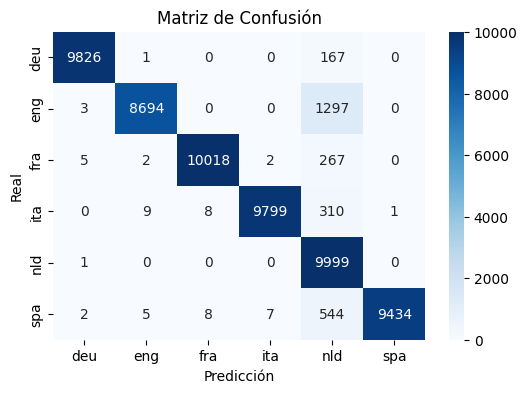

In [12]:
Files_classified, Files_origin = predict(test_files)
print(Fallados)
# Aplanar listas de listas
y_pred = [pred for sublist in Files_classified for pred in sublist]

y_true = Files_origin

# Calcular Accuracy
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

# Generar Matriz de Confusión
labels = sorted(set(y_true))  # Ordenar etiquetas únicas
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

# Visualizar la Matriz de Confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


### Análisis de los ejemplos fallados

Intentaremos definir cuales son las características de los ejemplos más fallados, por ejemplo, la longitud, el idioma o por la existencia de idiomas similares.

Longitud media de los textos fallidos: 439.8333333333333
Longitud mediana de los textos fallidos: 302.0
Longitud mínima de los textos fallidos: 1
Longitud máxima de los textos fallidos: 1300


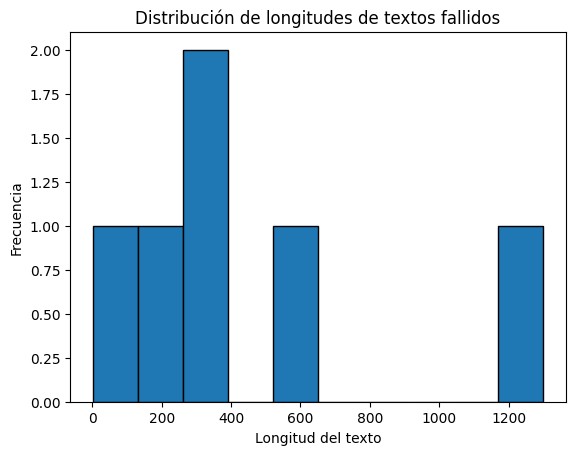

In [16]:
frases_fallidas = list(Fallados.values())

# Calcular la longitud de cada ejemplo fallido
longitudes_fallidos = [len(frase) for frase in frases_fallidas]

# Estadísticas básicas
print("Longitud media de los textos fallidos:", np.mean(longitudes_fallidos))
print("Longitud mediana de los textos fallidos:", np.median(longitudes_fallidos))
print("Longitud mínima de los textos fallidos:", np.min(longitudes_fallidos))
print("Longitud máxima de los textos fallidos:", np.max(longitudes_fallidos))

# Visualización
plt.hist(longitudes_fallidos, bins=10, edgecolor='black')
plt.xlabel("Longitud del texto")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitudes de textos fallidos")
plt.show()

Fallos por idioma: [('eng', 1300), ('spa', 566), ('ita', 328), ('fra', 276), ('deu', 168), ('nld', 1)]


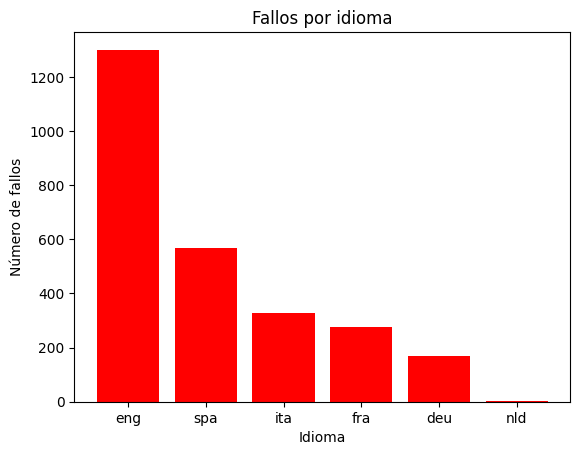

In [14]:
from collections import Counter

# Contar cuántas frases han fallado por idioma
fallos_por_idioma = {idioma: len(frases) for idioma, frases in Fallados.items()}

# Convertir a Counter para usar most_common()
fallos_por_idioma_counter = Counter(fallos_por_idioma)

# Mostrar los idiomas con más fallos
print("Fallos por idioma:", fallos_por_idioma_counter.most_common())

# Visualización
idiomas, frecuencias = zip(*fallos_por_idioma_counter.most_common())
plt.bar(idiomas, frecuencias, color='red')
plt.xlabel("Idioma")
plt.ylabel("Número de fallos")
plt.title("Fallos por idioma")
plt.show()